In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import h5py

import io
import time
import glob
import fnmatch
from itertools import chain, product
from textwrap import dedent
from collections import defaultdict
from collections import OrderedDict as odict
from os.path import exists
from pandas.api.types import union_categoricals

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter

from bokeh.io import push_notebook, show, output_notebook, output_file, save
from bokeh.models import Band, ColumnDataSource, CheckboxButtonGroup
from bokeh.models import TapTool, Select, Div, BoxZoomTool, ResetTool
from bokeh.models import HoverTool, CustomJS, TabPanel, Tabs
from bokeh.models import GroupFilter, CDSView, Slider, Range1d
from bokeh.plotting import figure 
from bokeh.layouts import gridplot, layout, row, column

import bspinn
from bspinn.io_utils import get_ovatgrps, drop_unqcols
from bspinn.io_cfg import configs_dir, results_dir
from bspinn.io_cfg import keyspecs, nullstr
from bspinn.io_utils import deep2hie, hie2deep
from bspinn.io_utils import save_h5data, load_h5data
from bspinn.io_utils import get_h5du, resio, get_dfidxs
from bspinn.summary import summarize

import yaml
from ruamel import yaml as ruyaml
from IPython import display as ICD

from bspinn.tch_utils import BatchRNG, bffnn
from bspinn.poisson import DeltaProblem
import torch

In [2]:
def sample_unifball(k, dim, np_random):
    c = np_random.randn(k, dim)
    c = c / np.linalg.norm(c, axis=1, keepdims=True)
    c = c * (np_random.rand(k, 1) ** (1./dim))
    return c

def get_rsamps(n_r, dim, hpdf, k=100000):
    # Checking that we're not handling irrelevant specs
    ad = {'eval/ur/dstr': 'uniform',
          'eval/ur/low': '[-1.0]',
          'eval/ur/high': '[1.0]',
          'eval/ub1/dstr': 'ball',
          'eval/ub1/c': '[0.0]',
          'eval/ub1/r': 1.0,
          'eval/ub2/dstr': 'ball',
          'eval/ub2/c': '[0.0]',
          'eval/ub2/r': 'sqrt(dim)',
          'eval/tv/dstr': 'trnvol',
          'vol/dstr': 'ball',
          'vol/c/dstr': 'ball',
          'vol/c/c': '[0.0]',
          'vol/c/r': 1.0,
          'vol/r/dstr': 'unifdpow',
          'vol/r/low': 0.0,
          'vol/r/high': 1.0}
    
    if hpdf is not None:
        for kk, vv in ad.items():
            if kk.startswith('eval/') and (kk not in hpdf):
                continue
            msg_ = f'{kk} != {vv} not supported!'
            assert np.array(hpdf[kk] == vv).all(), msg_
            
    # half-bin size
    hb = 1./(2.*n_r)
    # uniform representatives (i.e., quantiles)
    q = np.linspace(hb, 1.-hb, n_r)
    # The uniform radius (ur) representatives
    ur = q
    # The uniform ball with r=1 (ub1) representatives
    ub1 = q ** (1./dim)
    # The uniform ball with r=sqrt(dim) (ub2) representatives
    ub2 = ub1 * np.sqrt(dim)

    # Simulating the train volumnes (tv) representatives
    np_random = np.random.RandomState(12345)
    c = sample_unifball(k, dim, np_random)
    assert c.shape == (k, dim)
    r = np_random.rand(k, 1) ** (1./dim)
    assert r.shape == (k, 1)
    x = c + r * sample_unifball(k, dim, np_random)
    assert x.shape == (k, dim)
    xr = np.linalg.norm(x, axis=1)
    assert xr.shape == (k,)
    tv = np.percentile(xr, q*100)

    outdict = dict(q=q, ur=ur, ub1=ub1, ub2=ub2, tv=tv)
    return outdict

def mbeval_mdl(pnts, model, sd, n_seeds, n_r, n_eval, n_mdlseeds, dim):
    with torch.no_grad():
        u_mdllist = []
        for j1 in range(0, n_seeds, n_mdlseeds):
            j2 = min(n_seeds, j1 + n_mdlseeds)
            if (j2 - j1) < n_mdlseeds:
                ixlst = [min(x, n_seeds-1) for x in range(j1, j1 + n_mdlseeds)]
                prtlsd = {kk: vv[ixlst] for kk, vv in sd.items()}
                prtlpnts = pnts[ixlst]
                assert prtlpnts.shape == (n_mdlseeds, n_r, n_eval, dim)
            elif (j2 - j1) == n_mdlseeds:
                prtlsd = {kk: vv[j1: j2] for kk, vv in sd.items()}
                prtlpnts = pnts[j1: j2]
                assert prtlpnts.shape == (n_mdlseeds, n_r, n_eval, dim), f'{prtlpnts.shape}, {(n_mdlseeds, n_r, n_eval, dim)}'
            else:
                raise ValueError('should not happen')
            model.load_state_dict(prtlsd)
            prtl_umdl = model(prtlpnts)
            assert prtl_umdl.shape == (n_mdlseeds, n_r, n_eval, 1)

            u_mdllist.append(prtl_umdl[:(j2-j1)])
        u_mdl = torch.cat(u_mdllist, dim=0)
        assert u_mdl.shape == (n_seeds, n_r, n_eval, 1), f'{u_mdl.shape} != {(n_seeds, n_r, n_eval, 1)}, {[x.shape for x in u_mdllist]}'
    return u_mdl

def eval_rsol(fpidx, n_r, n_eval, n_q, eid_list, n_seeds, device_name):
    rio = resio(fpidx, full=False, driver=None)
    hpdf = rio('hp')
    
    hpdict = dict(hpdf.iloc[0])
    tch_device = torch.device(device_name)
    tch_dtype = torch.float32
    dim = hpdict['dim']
    rng = BatchRNG(shape=(n_seeds,), lib='torch', 
        device=tch_device, dtype=tch_dtype)

    # Creating a model instance for evaluation
    mlpspec = hie2deep(hpdict)['nn']
    assert mlpspec['dstr'] == 'mlp'
    
    # Since the network sizes can be too big to fit into memory, 
    # we have to load smaller chunks of models. `n_mdlseeds` is 
    # a rough estimate of how many seeds can fit into the memory.
    inp_neurons = [mlpspec['width']] * mlpspec['hidden'] + [1]
    out_neuroms = [dim] + [mlpspec['width']] * mlpspec['hidden']
    n_params = sum(i1*i2 for i1, i2 in zip(inp_neurons, out_neuroms))
    n_mdlseeds = 100 * (13000 / (n_params)) * (50 / n_r) * (1000 / n_eval)
    n_mdlseeds = min(int(n_mdlseeds), n_seeds)
    n_mdlseeds = max(n_mdlseeds, 1)
    rng_mdl = BatchRNG(shape=(n_mdlseeds,), lib='torch', 
        device=tch_device, dtype=tch_dtype)
    model = bffnn(dim, mlpspec['width'], mlpspec['hidden'], 
        mlpspec['act'], (n_mdlseeds,), rng_mdl)

    # Creating the problem instance
    cdict = {'chrg/dstr': 'dmm', 
            'chrg/n': 1, 
            'chrg/w': '[1.0]', 
            'chrg/mu': '[[0.0]]'}

    for kk, vv in cdict.items():
        assert hpdict[kk] == vv, f'{kk} should be {vv}'

    chrg_n = 1
    chrg_w = np.ones((n_seeds, chrg_n))
    chrg_mu = np.zeros((n_seeds, chrg_n, dim))
    
    problem = DeltaProblem(weights=chrg_w, locations=chrg_mu,
        tch_device=tch_device, tch_dtype=tch_dtype)
    
    # Collecting the model state dictionaries from the hdf file
    mdlkeys = [kk for kk in rio.keys() if kk.startswith('mdl/')]
    sdict, info = dict(), None
    for key in mdlkeys:
        sdkey = key.replace('mdl/', '')
        val_np, info = rio(key, ret_info=True)
        val = torch.from_numpy(val_np)
        val = val.to(device=tch_device, dtype=tch_dtype)
        sdict[sdkey] = val

    # Obtaining the ioidx array
    assert info is not None
    ioidx = info['ioidx'].values
    n_mdl = ioidx.size
    
    # Collecting the radius samples
    rdict = get_rsamps(n_r=n_r, dim=dim, hpdf=hpdict)
    rq = rdict['q']
    assert rq.shape == (n_r,)
    qout = torch.linspace(0, 1, n_q, device=tch_device, dtype=tch_dtype)
    for eid in eid_list:
        r_np = rdict[eid]
        assert r_np.shape == (n_r,)
        r_tch = torch.from_numpy(r_np)
        r_tch = r_tch.to(device=tch_device, dtype=tch_dtype)
        assert r_tch.shape == (n_r,)
        rdict[f'{eid}/tch'] = r_tch
    
    # Creating a number of unit points
    unitpnts = rng.normal((n_seeds, 1, n_eval, dim))
    assert unitpnts.shape == (n_seeds, 1, n_eval, dim)
    unitpnts = unitpnts / unitpnts.norm(p=2, dim=-1, keepdim=True)
    assert unitpnts.shape == (n_seeds, 1, n_eval, dim)
    
    # Evaluating the model on the sampled radius points
    n_for = int(np.ceil(ioidx.size/n_seeds))
    eid2uqlist = defaultdict(list)
    for ii in list(range(n_for)):
        sd = {kk: vv[ii*n_seeds:(ii+1)*n_seeds]
            for kk, vv in sdict.items()}
        
        for eid in eid_list:
            r_np = rdict[eid]
            assert r_np.shape == (n_r,)
            r_np_bc = np.broadcast_to(r_np[None, :], (n_seeds, n_r))
            assert r_np_bc.shape == (n_seeds, n_r)
            r_tch = rdict[f'{eid}/tch']
            assert r_tch.shape == (n_r,)    
            pnts = unitpnts * r_tch.reshape(1, n_r, 1, 1)
            assert pnts.shape == (n_seeds, n_r, n_eval, dim)
            
            assert (problem.n_chrg == 1)
            assert (problem.weights == 1).all()
            assert (problem.locations == 0).all()
            u_gt = problem.potential(pnts[:, :, 0, :])
            assert u_gt.shape == (n_seeds, n_r)
            uq_gt_np = u_gt.detach().cpu().numpy()
            assert uq_gt_np.shape == (n_seeds, n_r)
            
            
            # model.load_state_dict(sd)
            # u_mdl = model(pnts)
            # assert u_mdl.shape == (n_seeds, n_r, n_eval, 1)
            # The following is evaluating `model` on `pnts` in 
            # smaller batches and then concatenating them.
            u_mdl = mbeval_mdl(pnts, model, sd, n_seeds, n_r, n_eval, n_mdlseeds, dim)
            assert u_mdl.shape == (n_seeds, n_r, n_eval, 1)
            
            u_mdl_ = u_mdl.squeeze(dim=-1)
            assert u_mdl_.shape == (n_seeds, n_r, n_eval)
            uq_mdl_ = u_mdl_.quantile(q=qout, dim=-1)
            assert uq_mdl_.shape == (n_q, n_seeds, n_r)
            uq_mdl = uq_mdl_.permute(1, 2, 0)
            assert uq_mdl.shape == (n_seeds, n_r, n_q)
            uq_mdl_np = uq_mdl.detach().cpu().numpy()
            assert uq_mdl_np.shape == (n_seeds, n_r, n_q)
            
            eid2uqlist[f'{eid}/rsol/r'].append(r_np_bc)
            eid2uqlist[f'{eid}/rsol/gt'].append(uq_gt_np)
            eid2uqlist[f'{eid}/rsol/mdl'].append(uq_mdl_np)
    
    eid2uq = {eid: np.concatenate(uql, axis=0) for eid, uql in eid2uqlist.items()}
    # Example:
    #   eid2uq = {'ur/rsol/mdl':  np.array(...), # shape: (n_mdl, n_r, n_q)
    #             'ub1/rsol/mdl': np.array(...), # shape: (n_mdl, n_r, n_q)
    #             'ub2/rsol/mdl': np.array(...), # shape: (n_mdl, n_r, n_q)
    #             'tv/rsol/mdl':  np.array(...), # shape: (n_mdl, n_r, n_q)
    #             'ur/rsol/gt':   np.array(...), # shape: (n_mdl, n_r)
    #             'ub1/rsol/gt':  np.array(...), # shape: (n_mdl, n_r)
    #             'ub2/rsol/gt':  np.array(...), # shape: (n_mdl, n_r)
    #             'tv/rsol/gt':   np.array(...), # shape: (n_mdl, n_r)
    #             'ur/rsol/r':    np.array(...), # shape: (n_mdl, n_r)
    #             'ub1/rsol/r':   np.array(...), # shape: (n_mdl, n_r)
    #             'ub2/rsol/r':   np.array(...), # shape: (n_mdl, n_r)
    #             'tv/rsol/r':    np.array(...)} # shape: (n_mdl, n_r)
    
    savedata = {f'P{pidx:08d}/var/eval/{eid}/rsol/ioidx': ioidx for eid in eid_list}
    savedata[f'P{pidx:08d}/var/eval'] = eid2uq
    savedata = deep2hie(savedata)
    # Example:
    #   savedata is a key to np.array mapping with the following shapes:
    #     {'P00000000/var/eval/ur/rsol/ioidx':  (n_mdl,),
    #      'P00000000/var/eval/ub1/rsol/ioidx': (n_mdl,),
    #      'P00000000/var/eval/ub2/rsol/ioidx': (n_mdl,),
    #      'P00000000/var/eval/tv/rsol/ioidx':  (n_mdl,),
    #      'P00000000/var/eval/ur/rsol/r':      (n_mdl, n_r),
    #      'P00000000/var/eval/ur/rsol/gt':     (n_mdl, n_r),
    #      'P00000000/var/eval/ur/rsol/mdl':    (n_mdl, n_r, n_q),
    #      'P00000000/var/eval/ub1/rsol/r':     (n_mdl, n_r),
    #      'P00000000/var/eval/ub1/rsol/gt':    (n_mdl, n_r),
    #      'P00000000/var/eval/ub1/rsol/mdl':   (n_mdl, n_r, n_q),
    #      'P00000000/var/eval/ub2/rsol/r':     (n_mdl, n_r),
    #      'P00000000/var/eval/ub2/rsol/gt':    (n_mdl, n_r),
    #      'P00000000/var/eval/ub2/rsol/mdl':   (n_mdl, n_r, n_q),
    #      'P00000000/var/eval/tv/rsol/r':      (n_mdl, n_r),
    #      'P00000000/var/eval/tv/rsol/gt':     (n_mdl, n_r),
    #      'P00000000/var/eval/tv/rsol/mdl':    (n_mdl, n_r, n_q)}
    return savedata

def get_method(df):
    method_col = []
    for i, row in df.iterrows():
        method = 'Expensive' if row['srfpts/n/trg'] > 2 else 'Cheap'
        if row['trg/btstrp']:
            method += ' Bootstrapping'
            if (row['trg/tau'] == 0.984) and (row['trg/reg/w'] == 2.0):
                method += '+'
        elif row['srfpts/dblsmpl']:
            method += ' Double-Sampling'
        else:
            method += ' Standard'
        method_col.append(method)
    return method_col

def get_method2(df):
    i_bts = (df['trg/btstrp'] == True)
    i_ds = (df['srfpts/dblsmpl'] == True)
    i_gq = (df['srfpts/samp/dstr'] == 'quad') & (df['srfpts/samp/rule']=='gaussian')
    i_qmc = (df['srfpts/samp/dstr'] == 'qmc')
    i_lq = (df['srfpts/samp/dstr'] == 'quad') & (df['srfpts/samp/rule']=='leja')
    i_std = (df['srfpts/samp/dstr'] == 'rng') & (~i_bts) & (~i_ds)
    n_sim = df['srfpts/n/trg'] + df['srfpts/n/mdl'] - 1
    n_sim[n_sim == 99] = 100

    df.loc[i_bts, 'method'] = 'Delayed Target'
    df.loc[i_ds,  'method'] = 'Double Sampling'
    df.loc[i_gq,  'method'] = 'Gaussian Quadrature'
    df.loc[i_lq,  'method'] = 'Leja Quadrature'
    df.loc[i_qmc, 'method'] = 'QMC'
    df.loc[i_std, 'method'] = 'Standard'
    not_quad = (df['srfpts/samp/dstr'] != 'quad')
    df.loc[not_quad, 'method'] += ' (N=' + n_sim.loc[not_quad].astype('str') + ')'
    method_col = df['method']
    df.drop(columns='method', inplace=True)
    return method_col

def get_solperf(rsol_r1, rsol_gt1, rsol_mdl1, 
    device_name=None, n_eval=10000):
    if device_name is None:
        device_name = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    tch_device = torch.device(device_name)
    
    n_r, n_q = rsol_mdl1.shape[-2:]
    odims = rsol_mdl1.shape[:-2]
    n_cfgseeds = np.prod(odims)
    
    rsol_r2_all = rsol_r1.reshape(n_cfgseeds, n_r)
    assert rsol_r2_all.shape == (n_cfgseeds, n_r)
    rsol_gt2_all = rsol_gt1.reshape(n_cfgseeds, n_r, 1)
    assert rsol_gt2_all.shape == (n_cfgseeds, n_r, 1)
    rsol_mdl2_all = rsol_mdl1.reshape(n_cfgseeds, n_r, n_q)
    assert rsol_mdl2_all.shape == (n_cfgseeds, n_r, n_q)

    n_batches = int(np.ceil(n_cfgseeds/n_eval))
    
    catlist = []
    for i_mb in range(n_batches):
        i1 = i_mb * n_eval
        i2 = (i_mb + 1) * n_eval
        
        rsol_r2 = rsol_r2_all[i1:i2, ...]
        n_mb = rsol_r2.shape[0]
        assert rsol_r2.shape  == (n_mb, n_r)
        
        rsol_gt2 = rsol_gt2_all[i1:i2, ...]
        assert rsol_gt2.shape == (n_mb, n_r, 1)
        
        rsol_mdl2 = rsol_mdl2_all[i1:i2, ...]
        assert rsol_mdl2.shape == (n_mb, n_r, n_q)
        
        rsol_r2 = torch.from_numpy(rsol_r2).to(tch_device)
        rsol_gt2 = torch.from_numpy(rsol_gt2).to(tch_device)
        rsol_mdl2 = torch.from_numpy(rsol_mdl2).to(tch_device)
        
        # Plain
        rsol_err1 = rsol_mdl2 - rsol_gt2
        assert rsol_err1.shape == (n_mb, n_r, n_q)

        # Unbiased
        rsol_mdl3 = rsol_mdl2 - rsol_mdl2.mean(dim=(-1, -2), keepdims=True)
        assert rsol_mdl3.shape == (n_mb, n_r, n_q)

        rsol_gt3 = rsol_gt2 - rsol_gt2.mean(dim=(-1, -2), keepdims=True)
        assert rsol_gt3.shape == (n_mb, n_r, 1)

        rsol_err2 = rsol_mdl3 - rsol_gt3
        assert rsol_err2.shape == (n_mb, n_r, n_q)

        # Unbiased
        rsol_mdl4 = rsol_mdl3 / rsol_mdl3.std(dim=(-1, -2), keepdims=True)
        assert rsol_mdl4.shape == (n_mb, n_r, n_q)

        rsol_gt4 = rsol_gt3 / rsol_gt3.std(dim=(-1, -2), keepdims=True)
        assert rsol_gt4.shape == (n_mb, n_r, 1)

        rsol_err3 = rsol_mdl4 - rsol_gt4
        assert rsol_err3.shape == (n_mb, n_r, n_q)


        rsol_mse1 = rsol_err1.square().mean(dim=(-1, -2))
        assert rsol_mse1.shape == (n_mb,)

        rsol_mae1 = rsol_err1.abs().mean(dim=(-1, -2))
        assert rsol_mae1.shape == (n_mb,)

        rsol_mse2 = rsol_err2.square().mean(dim=(-1, -2))
        assert rsol_mse2.shape == (n_mb,)

        rsol_mae2 = rsol_err2.abs().mean(dim=(-1, -2))
        assert rsol_mae2.shape == (n_mb,)

        rsol_mse3 = rsol_err3.square().mean(dim=(-1, -2))
        assert rsol_mse2.shape == (n_mb,)

        rsol_mae3 = rsol_err3.abs().mean(dim=(-1, -2))
        assert rsol_mae2.shape == (n_mb,)
        
        meanerrs = (rsol_mse1, rsol_mae1, rsol_mse2, rsol_mae2, rsol_mse3, rsol_mae3)
        catlist.append(tuple(v.detach().cpu().numpy() for v in meanerrs))
    
    names = ('pln/mse', 'pln/mae', 'bc/mse', 'bc/mae', 'bcn/mse', 'bcn/mae')
    aa = [[x[i] for x in catlist] for i in range(len(names))]
    outdict = dict()
    for name, valslist in zip(names, aa):
        val = np.concatenate(valslist, axis=0)
        val = val.reshape(*odims, *val.shape[1:])
        outdict[name] = val
        
    return outdict


In [3]:
workdir = './28_hdpviz'
! mkdir -p {workdir}

# Plotting the Evaluation Point Radius Distributions

This section is only for basic raidus distribution visualizations. 

You can skip this step safely if it errors out due to lacking results files.

In [4]:
fpidx = '01_poisson/26_hindim.0.0'
rio = resio(fpidx, full=False, driver=None)
hpdf = rio('hp')

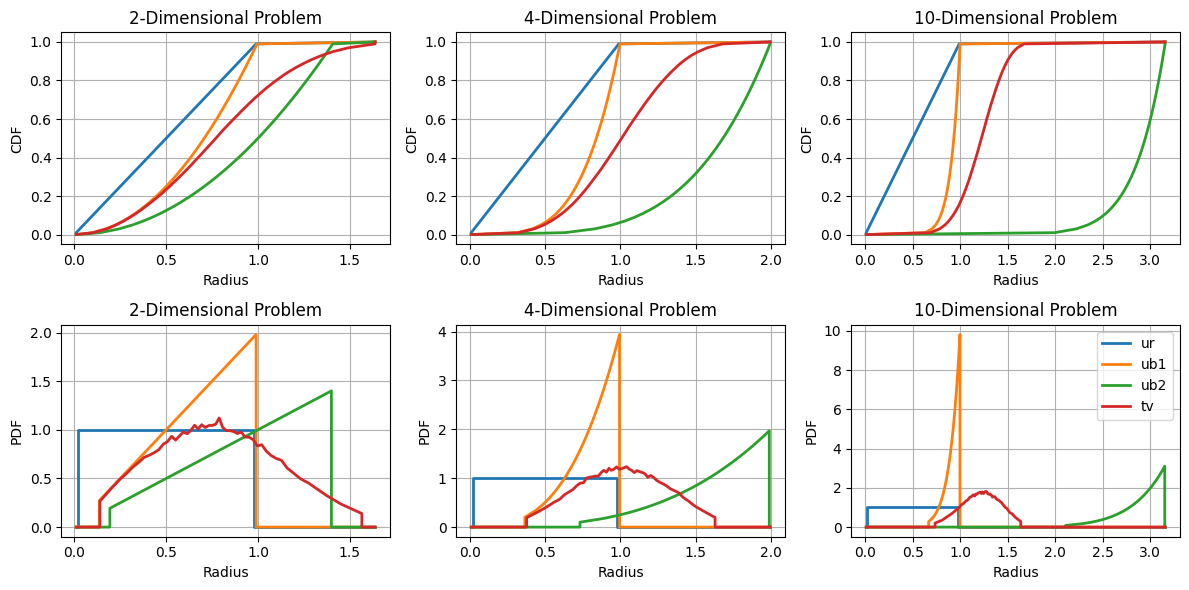

In [ ]:
n_rows, n_cols = 2, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4,n_rows*3), 
    dpi=100, sharex=False, sharey=False)
axes = np.array(axes).reshape(n_rows, n_cols).reshape(-1)
rid_list = ['ur', 'ub1', 'ub2', 'tv']
n_r = 50
for ax_idx, (yaxis,  dim) in enumerate(product(['cdf', 'pdf'], [2, 4, 10])):
    ax = axes[ax_idx]
    rdict = get_rsamps(n_r=n_r, dim=dim, hpdf=hpdf)
    q = rdict['q']
    dq = np.diff(q)
    r_min = min(rdict[rid][0] for rid in rid_list)
    r_max = max(rdict[rid][-1] for rid in rid_list)
    for rid in rid_list:
        rp = rdict[rid]
        if yaxis == 'cdf':
            x = [r_min] + rp.tolist() + [r_max] 
            y = [0.0] + q.tolist() + [1.0]
        elif yaxis == 'pdf':
            r = rp[:-1] + np.diff(rp)/2
            rpdf = dq / np.diff(rp)
            x = [r_min, r[0]] + r.tolist() + [r[-1], r_max]
            y = [0.0, 0.0] + rpdf.tolist() + [0.0, 0.0]
        else:
            raise ValueError(f'yaxis={yaxis} undef')
        ax.plot(x, y, label=rid, lw=2)

    ax.grid()
    ax.set_ylabel(yaxis.upper())
    ax.set_xlabel('Radius')
    ax.set_title(f'{dim}-Dimensional Problem')

ax.legend()
fig.set_tight_layout(True)
fig.savefig(f'{workdir}/00_rdistr.pdf', dpi=200, bbox_inches="tight")

# Collecting the Dashboard Data

**Context**: 

We're dealing with a single Dirac-delta charge located at zero in a poisson problem with 2-10 dimensions.

The next cell will load the neural network checkpoints, and evaluate them on a bunch of points with deterministically sampled radi.

The radius resolution is determined by the `n_r` hyper-parameter; the numbe of radi we will use in point evaluations.

Due to storage limitations, we use `n_q=5` and only store five percentiles:
  
  * (min, lower-quartile, median, higher-quartile, and max) for the 1000 sampled point solutions at each radius.

This was done for the `['ur', 'ub1', 'ub2', 'tv']` evaluation profiles.

**Important Note**: Running this notebook on many of the following `cfg_trees` will result in the process going out-of-memory and getting killed.

This is happening because the `resio` object will load the entire HDF files into memory before creating the data-frames.

To solve this, replace an entire `fpidx` with more atomic ones.

For instance, if `01_poisson/26_hindim` has 

  * 4 result files (i.e., `results/01_poisson/26_hindim_00.h5`, ..., `results/01_poisson/26_hindim_03.h5`), and

  * 5 parts in each file (i.e., `P00000000`, ..., `P00000004`), 

you can replace 

`cfg_tree = ['01_poisson/26_hindim']` 

with either

`cfg_tree = [f'01_poisson/26_hindim.{i}.*' for i in range(4)]`

or 

`cfg_tree = [f'01_poisson/26_hindim.{i}.{j}' for i in range(4) for j in range(5)]`

(the last one is even more atomic and can fit into smaller memory sizes).

In [7]:
cfg_trees = [['01_poisson/21_hindim'], ['01_poisson/26_hindim']]

n_eval = 1000
n_seeds = 100
device_name = 'cuda:0'

# Note: only for the 'tv' evaluation profile, we used 
#       'n_q' equal to both 5 and 101, and named them
#       'tv' and 'tv2' in the hdf files, respectively.
n_r_list   =  [ 50,                           50    ] # n_r values
n_q_list   =  [ 5,                            101   ] # n_q values
eid_lists  =  [['ur', 'ub1', 'ub2',  'tv'],  ['tv'] ] # eval id names for running the protocol
oeid_lists =  [['ur', 'ub1', 'ub2',  'tv'],  ['tv2']] # output eval id names in the summary hdf files

In [9]:
for cfg_tree in cfg_trees:
    rio = resio(cfg_tree, full=True, driver=None)
    dtdict = rio.dtypes()

    for n_q, n_r, eid_list, oeid_list_ in zip(n_q_list, n_r_list, eid_lists, oeid_lists):
        # Example: 
        #   n_q = 5
        #   eid_list = ['ur', 'ub1', 'ub2',  'tv']
        #   oeid_list = ['ur', 'ub1', 'ub2',  'tv']
        oeid_list = eid_list if oeid_list_ is None else oeid_list_
        assert len(eid_list) == len(oeid_list)
        hdfpath2data = defaultdict(dict)
        for fpidx, key2dtype in hie2deep(dtdict, sep=':').items():
            #if not any(fpidx.endswith(x) for x in ('0.16', '0.18', '1.17')):
            #    continue
            cfg_tree, fidx, pidx = fpidx.split('.')
            fidx, pidx = int(fidx), int(pidx)
            pats = [f'var/eval/{oeid}/rsol/*' for oeid in oeid_list]
            exists_rsol = all(any(fnmatch.fnmatch(key, pat) 
                                for key in key2dtype)
                            for pat in pats)
            # exists_rsol = False
            if (not exists_rsol):
                print(f'Working on {fpidx}...')
                fpidx = f'{cfg_tree}.{fidx}.{pidx}'
                fpisavedata_ = eval_rsol(fpidx, n_r, n_eval, n_q, 
                    eid_list, n_seeds, device_name)
                
                # Example: the following replaces '/tv/' with '/tv2/' 
                #          in the 'var/eval/tv/rsol/mdl' key name.
                fpisavedata = dict()
                for key, np_arr in fpisavedata_.items():
                    for eid_, oeid_ in zip(eid_list, oeid_list):
                        key = key.replace(f'/{eid_}/', f'/{oeid_}/')
                    fpisavedata[key] = np_arr
                    
                hdfpath = f'{results_dir}/{cfg_tree}_{fidx:02d}.h5'
                hdfpath2data[hdfpath].update(fpisavedata)
                print(f'Finished working on {fpidx}.')

        if len(hdfpath2data) > 0:
            # Closing the resio instance since we have to write down the results.
            rio.close()
            for hdfpath, savedata in hdfpath2data.items():
                with h5py.File(hdfpath, mode="a") as h5hdf:
                    for key, np_arr in savedata.items():
                        if key in h5hdf:
                            h5hdf[key][...] = np_arr
                        else:
                            h5hdf.create_dataset(
                                key,
                                shape=np_arr.shape,
                                dtype=np_arr.dtype,
                                data=np_arr,
                                compression="gzip",
                                compression_opts=0,
                            )

Working on 01_poisson/26_hindim.1.0...
Finished working on 01_poisson/26_hindim.1.0.
Working on 01_poisson/26_hindim.1.1...
Finished working on 01_poisson/26_hindim.1.1.
Working on 01_poisson/26_hindim.1.2...
Finished working on 01_poisson/26_hindim.1.2.
Working on 01_poisson/26_hindim.2.0...
Finished working on 01_poisson/26_hindim.2.0.
Working on 01_poisson/26_hindim.2.1...
Finished working on 01_poisson/26_hindim.2.1.
Working on 01_poisson/26_hindim.3.0...
Finished working on 01_poisson/26_hindim.3.0.
Working on 01_poisson/26_hindim.3.1...
Finished working on 01_poisson/26_hindim.3.1.


# Plotting the Solution vs. Radius Figures for Different Methods

In [6]:
rio = resio(['01_poisson/21_hindim', '01_poisson/26_hindim'], full=True, driver=None)

In [7]:
cache_path = f'{workdir}/14_hdpviz.h5'
# ! rm {cache_path}
if exists(cache_path):
    cache_data = load_h5data(cache_path, driver=None)
    hpdf = cache_data['hp']
    stdf = cache_data['stat']
else:
    eid_list = ['ur', 'ub1', 'ub2', 'tv']
    
    hpdf1, hpinfo = rio('hp', ret_info=True)
    hpdf1['fpidx'] = hpinfo['fpidx']
    hpdf2 = hpdf1.groupby('fpidx').agg('last').reset_index()
    hpdf3 = drop_unqcols(hpdf2)
    hpdf3['method'] = get_method2(hpdf3)

    estdf_list, ehpdf_list = [], []
    for eid in eid_list:
        print('.', end='', flush=True)
        rsol_r1,   info1 = rio(f'var/eval/{eid}/rsol/r', ret_info=True)
        rsol_gt1,  info2 = rio(f'var/eval/{eid}/rsol/gt', ret_info=True)
        rsol_mdl1, info3 = rio(f'var/eval/{eid}/rsol/mdl', ret_info=True)

        assert info1.equals(info2)
        assert info1.equals(info3)
        info4 = info1

        n_r, n_q = rsol_mdl1.shape[1:]
        assert rsol_r1.shape[1:]   == (n_r,)
        assert rsol_gt1.shape[1:]  == (n_r,)
        assert rsol_mdl1.shape[1:] == (n_r, n_q)

        info4 = info4.reset_index(drop=True)
        info5 = info4.sort_values(by=['fpidx', 'epoch', 'rng_seed'])
        a = [df.shape[0] for _, df in info5.groupby(['fpidx', 'epoch'])]
        assert len(set(a)) == 1
        n_seeds = a[0]

        if not (info5.index.values == np.arange(info5.shape[0])).all():
            rsol_mdl1 = rsol_mdl1[info5.index.values]
            rsol_gt1 = rsol_gt1[info5.index.values]
            rsol_r1 = rsol_r1[info5.index.values]
        info6 = info5.reset_index(drop=True)

        # average-aggregating the rng_seeds
        info7 = info6.iloc[::n_seeds].drop(columns='rng_seed')
        info = info7.reset_index(drop=True)
        rsol_r = rsol_r1.reshape(-1, n_seeds, n_r).mean(axis=1)
        rsol_gt = rsol_gt1.reshape(-1, n_seeds, n_r).mean(axis=1)
        rsol_mdl = rsol_mdl1.reshape(-1, n_seeds, n_r, n_q).mean(axis=1)
        n_cfg = rsol_r.shape[0]
        assert rsol_r.shape   == (n_cfg, n_r)
        assert rsol_gt.shape  == (n_cfg, n_r)
        assert rsol_mdl.shape == (n_cfg, n_r, n_q)

        x = rsol_r.reshape(n_cfg*n_r)
        y1 = rsol_mdl.reshape(n_cfg*n_r, n_q)
        y2 = rsol_gt.reshape(n_cfg*n_r)
        estdict = {'x': x,
                'y1/mean': y1[:, n_q//2],
                'y1/low': y1[:, 0],
                'y1/high': y1[:, -1],
                'y2': y2,
                'eid': eid}
        estdf = pd.DataFrame(estdict)
        
        hpdf4 = hpdf3.set_index('fpidx').loc[info['fpidx'], :].reset_index()
        hpdf4['epoch'] = info['epoch']

        hpdf5 = hpdf4.iloc[np.arange(n_cfg).repeat(n_r), :]
        hpdf5 = hpdf5.reset_index(drop=True)
        ehpdf = hpdf5.drop(columns=['fpidx'])
        
        estdf_list.append(estdf)
        ehpdf_list.append(ehpdf)
        
    stdf = pd.concat(estdf_list, axis=0, ignore_index=True)
    hpdf = pd.concat(ehpdf_list, axis=0, ignore_index=True)
    
    cache_data = {'hp': hpdf, 'stat': stdf}
    save_h5data(cache_data, cache_path, driver=None)

In [8]:
hpdf['method'] = get_method2(hpdf)
# Stacking the hyper-parameter and statistics data-frames
fdf = pd.concat([hpdf, stdf], axis=1)

# Lowering the storage requirement by droping some epochs 
i1 = (fdf['epoch'] % 20000) == 0
i2 = (fdf['epoch'] < 40000)
fdf = fdf[(i1 | i2)]

i3 = (fdf['srfpts/n/mdl'] == 1) & (fdf['trg/btstrp'] == True)
i4 = (fdf['trg/w'] == 0.998)
fdf = fdf[(~i3) | i4]

i5 = (fdf['srfpts/n/mdl'] == 6) & (fdf['trg/btstrp'] == True)
i6 = (fdf['trg/w'] == 0.996)
fdf = fdf[(~i5) | i6]

# Renaming the columns and the menu contents
a = ['ur', 'ub1', 'ub2', 'tv']
b = ['Uniform Rectangle', 'Uniform Ball (R=1)', 
     'Uniform Ball (R=Sqrt(Dim))', 'Training Volumes']
fdf['eid'] = fdf['eid'].replace(a, b)
col_renames = {'eid': 'Evaluation Profile', 'dim': 'Dimension', 'epoch': 'Epoch'}
fdf = fdf.rename(columns=col_renames)

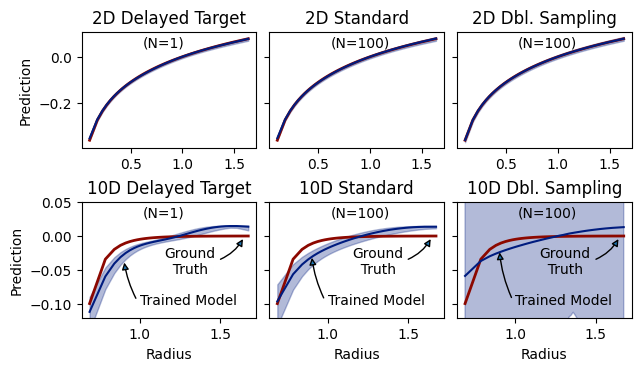

In [9]:
conds = {'Evaluation Profile': 'Training Volumes', 'Epoch':  200000}
i1 = get_dfidxs(fdf, conds)
pltdf = fdf.copy(deep=True).loc[i1].reset_index(drop=True)

nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2.1, nrows*1.8), 
    dpi=100, sharex=False, sharey='row', constrained_layout = True)
axes = np.array(axes).reshape(nrows, ncols)

snspald = {'blue': '#001c7f', 'orange': '#b1400d', 'green': '#12711c', 
    'red': '#8c0800', 'purple': '#591e71', 'brown': '#592f0d', 'pink': '#a23582',
    'gray': '#3c3c3c', 'yellow': '#b8850a', 'cyan': '#006374', 'black': '#000000'}

pltcfgs = [(2,  'Delayed Target (N=1)', '2D Delayed Target\n          (N=1)'), 
           (2,  'Standard (N=100)', '      2D Standard\n          (N=100)'), 
           (2,  'Double Sampling (N=100)', ' 2D Dbl. Sampling\n         (N=100)'),
           (10, 'Delayed Target (N=1)', '10D Delayed Target\n          (N=1)'), 
           (10, 'Standard (N=100)', '    10D Standard\n          (N=100)'), 
           (10, 'Double Sampling (N=100)', '10D Dbl. Sampling\n         (N=100)')]

for i_ax, (dim, method, ttl) in enumerate(pltcfgs):
    ax = axes.ravel()[i_ax]
    i2 = get_dfidxs(pltdf, {'Dimension': dim, 'method': method})
    pltdf2 = pltdf.loc[i2]
    y2 = pltdf2['y2'].values
    y1, y1l, y1h = pltdf2['y1/mean'].values, pltdf2['y1/low'].values, pltdf2['y1/high'].values
    y2p = y2 - y2.mean() + y2.mean()
    y1p = y1 - y1.mean() + y2.mean()
    y1lp = y1l - y1.mean() + y2.mean()
    y1hp = y1h - y1.mean() + y2.mean()
    ax.plot(pltdf2['x'], y2p, color=snspald['red'], lw=2)
    ax.plot(pltdf2['x'], y1p, color=snspald['blue'])
    ax.fill_between(pltdf2['x'], y1lp, y1hp, color=snspald['blue'], alpha=0.3)

    ttl1, ttl2 = ttl.split('\n')
    ax.set_title(ttl1.strip())
    ax.annotate(xy=(0.35, 0.87), text=ttl2.strip(), xytext=(0.35, 0.87), 
        xycoords='axes fraction', textcoords='axes fraction')

    if dim == 10:
        ax.set_xticks([1.0, 1.5])
        ax.set_ylim(-0.12, 0.05)
        ax.set_xlabel('Radius')
        ax.annotate(xytext=(1.15, -0.055), xy=(1.65, -0.001), text='Ground\n  Truth', 
             arrowprops=dict(arrowstyle="-|>", relpos=(1.0, 0.5), connectionstyle="arc3,rad=0.2"))

        y_arrow = [-0.035, -0.028, -0.02][i_ax % ncols]
        ax.annotate(xytext=(1.0, -0.1), xy=(0.9, y_arrow), text='Trained Model', 
             arrowprops=dict(arrowstyle="-|>", relpos=(0.0, 0.1), connectionstyle="arc3,rad=-0.1"))
    
    if i_ax % ncols == 0:
        ax.set_ylabel('Prediction')

In [16]:
fig.savefig(f'{workdir}/15_pred_vs_radius_hdp.pdf', bbox_inches="tight")

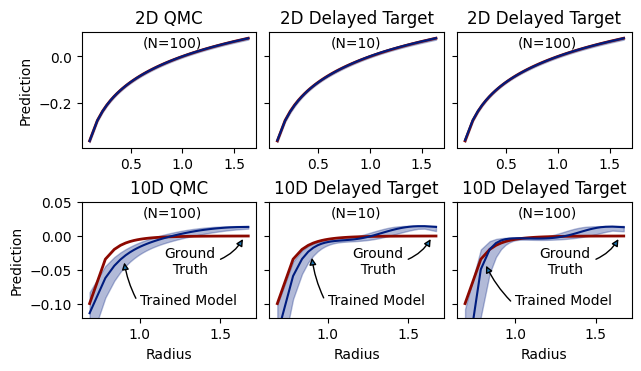

In [17]:
conds = {'Evaluation Profile': 'Training Volumes', 'Epoch':  200000}
i1 = get_dfidxs(fdf, conds)
pltdf = fdf.copy(deep=True).loc[i1].reset_index(drop=True)

nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2.1, nrows*1.8), 
    dpi=100, sharex=False, sharey='row', constrained_layout = True)
axes = np.array(axes).reshape(nrows, ncols)

snspald = {'blue': '#001c7f', 'orange': '#b1400d', 'green': '#12711c', 
    'red': '#8c0800', 'purple': '#591e71', 'brown': '#592f0d', 'pink': '#a23582',
    'gray': '#3c3c3c', 'yellow': '#b8850a', 'cyan': '#006374', 'black': '#000000'}

pltcfgs = [(2,  'QMC (N=100)',  '    2D QMC\n          (N=100)'),
           (2,  'Delayed Target (N=10)', '2D Delayed Target\n          (N=10)'),
           (2,  'Delayed Target (N=100)', '2D Delayed Target\n          (N=100)'),
           (10, 'QMC (N=100)', '    10D QMC\n          (N=100)'),            
           (10, 'Delayed Target (N=10)', '10D Delayed Target\n         (N=10)'),
           (10, 'Delayed Target (N=100)', '10D Delayed Target\n         (N=100)')]

for i_ax, (dim, method, ttl) in enumerate(pltcfgs):
    ax = axes.ravel()[i_ax]
    i2 = get_dfidxs(pltdf, {'Dimension': dim, 'method': method})
    pltdf2 = pltdf.loc[i2]
    y2 = pltdf2['y2'].values
    y1, y1l, y1h = pltdf2['y1/mean'].values, pltdf2['y1/low'].values, pltdf2['y1/high'].values
    y2p = y2 - y2.mean() + y2.mean()
    y1p = y1 - y1.mean() + y2.mean()
    y1lp = y1l - y1.mean() + y2.mean()
    y1hp = y1h - y1.mean() + y2.mean()
    ax.plot(pltdf2['x'], y2p, color=snspald['red'], lw=2)
    ax.plot(pltdf2['x'], y1p, color=snspald['blue'])
    ax.fill_between(pltdf2['x'], y1lp, y1hp, color=snspald['blue'], alpha=0.3)

    ttl1, ttl2 = ttl.split('\n')
    ax.set_title(ttl1.strip())
    ax.annotate(xy=(0.35, 0.87), text=ttl2.strip(), xytext=(0.35, 0.87), 
        xycoords='axes fraction', textcoords='axes fraction')

    if dim == 10:
        ax.set_xticks([1.0, 1.5])
        ax.set_ylim(-0.12, 0.05)
        ax.set_xlabel('Radius')
        ax.annotate(xytext=(1.15, -0.055), xy=(1.65, -0.001), text='Ground\n  Truth', 
             arrowprops=dict(arrowstyle="-|>", relpos=(1.0, 0.5), connectionstyle="arc3,rad=0.2"))

        y_arrow = [-0.035, -0.028, -0.04][i_ax % ncols]
        x_arrow = [0.9   ,    0.9,  0.81][i_ax % ncols]
        ax.annotate(xytext=(1.0, -0.1), xy=(x_arrow, y_arrow), text='Trained Model', 
             arrowprops=dict(arrowstyle="-|>", relpos=(0.0, 0.1), connectionstyle="arc3,rad=-0.1"))
    
    if i_ax % ncols == 0:
        ax.set_ylabel('Prediction')

In [18]:
fig.savefig(f'{workdir}/16_pred_vs_radius_hdp.pdf', bbox_inches="tight")

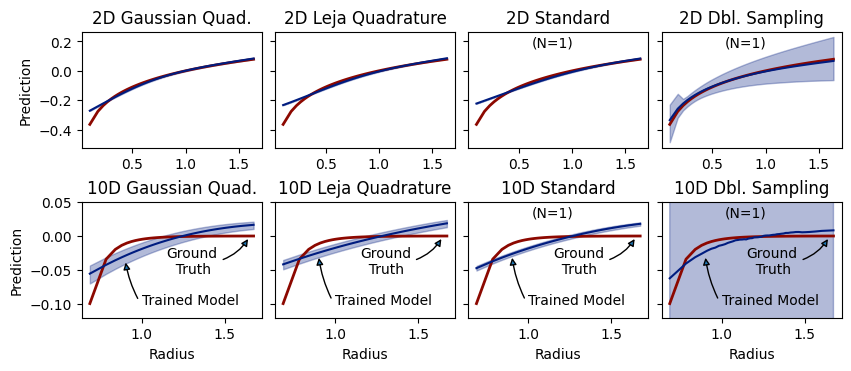

In [19]:
conds = {'Evaluation Profile': 'Training Volumes', 'Epoch':  200000}
i1 = get_dfidxs(fdf, conds)
pltdf = fdf.copy(deep=True).loc[i1].reset_index(drop=True)

nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2.1, nrows*1.8), 
    dpi=100, sharex=False, sharey='row', constrained_layout = True)
axes = np.array(axes).reshape(nrows, ncols)

snspald = {'blue': '#001c7f', 'orange': '#b1400d', 'green': '#12711c', 
    'red': '#8c0800', 'purple': '#591e71', 'brown': '#592f0d', 'pink': '#a23582',
    'gray': '#3c3c3c', 'yellow': '#b8850a', 'cyan': '#006374', 'black': '#000000'}

pltcfgs = [(2,  'Gaussian Quadrature', '2D Gaussian Quad.\n'),
           (2,  'Leja Quadrature', '2D Leja Quadrature\n'),
           (2,  'Standard (N=1)', '      2D Standard\n          (N=1)'), 
           (2,  'Double Sampling (N=1)', ' 2D Dbl. Sampling\n         (N=1)'),
           (10, 'Gaussian Quadrature', '10D Gaussian Quad.\n'), 
           (10, 'Leja Quadrature', '10D Leja Quadrature\n'), 
           (10, 'Standard (N=1)', '    10D Standard\n          (N=1)'), 
           (10, 'Double Sampling (N=1)', '10D Dbl. Sampling\n         (N=1)')]

for i_ax, (dim, method, ttl) in enumerate(pltcfgs):
    ax = axes.ravel()[i_ax]
    i2 = get_dfidxs(pltdf, {'Dimension': dim, 'method': method})
    pltdf2 = pltdf.loc[i2]
    y2 = pltdf2['y2'].values
    y1, y1l, y1h = pltdf2['y1/mean'].values, pltdf2['y1/low'].values, pltdf2['y1/high'].values
    y2p = y2 - y2.mean() + y2.mean()
    y1p = y1 - y1.mean() + y2.mean()
    y1lp = y1l - y1.mean() + y2.mean()
    y1hp = y1h - y1.mean() + y2.mean()
    ax.plot(pltdf2['x'], y2p, color=snspald['red'], lw=2)
    ax.plot(pltdf2['x'], y1p, color=snspald['blue'])
    ax.fill_between(pltdf2['x'], y1lp, y1hp, color=snspald['blue'], alpha=0.3)

    ttl1, ttl2 = ttl.split('\n')
    ax.set_title(ttl1.strip())
    ax.annotate(xy=(0.35, 0.87), text=ttl2.strip(), xytext=(0.35, 0.87), 
        xycoords='axes fraction', textcoords='axes fraction')

    if dim == 10:
        ax.set_xticks([1.0, 1.5])
        ax.set_ylim(-0.12, 0.05)
        ax.set_xlabel('Radius')
        ax.annotate(xytext=(1.15, -0.055), xy=(1.65, -0.001), text='Ground\n  Truth', 
             arrowprops=dict(arrowstyle="-|>", relpos=(1.0, 0.5), connectionstyle="arc3,rad=0.2"))

        y_arrow = [-0.035, -0.028, -0.028, -0.028][i_ax % ncols]
        x_arrow = [0.9   ,    0.9,    0.9,    0.9][i_ax % ncols]
        ax.annotate(xytext=(1.0, -0.1), xy=(x_arrow, y_arrow), text='Trained Model', 
             arrowprops=dict(arrowstyle="-|>", relpos=(0.0, 0.1), connectionstyle="arc3,rad=-0.1"))
    
    if i_ax % ncols == 0:
        ax.set_ylabel('Prediction')

In [20]:
fig.savefig(f'{workdir}/17_pred_vs_radius_hdp.pdf', bbox_inches="tight")

# Creating the Dashboard

In [10]:
output_notebook()

# Dropping the unneeded columns
fdf2 = fdf.drop(columns=['srfpts/samp/dstr', 'srfpts/trnsfrm/dstr', 'vol/n',
       'srfpts/n/mdl', 'srfpts/n/trg', 'srfpts/dblsmpl', 'trg/btstrp',
       'trg/tau', 'trg/reg/w', 'trg/w', 'srfpts/samp/order',
       'srfpts/trnsfrm/n_cdfint', 'srfpts/samp/sparse', 'srfpts/samp/rcuralg',
fdf2 = fdf2.reset_index(drop=True)

Loading BokehJS ...

In [28]:
ncols = 4
slider_cols = [col_renames[c] for c in ['eid', 'dim', 'epoch']]
colors = ['#001c7f', '#b1400d', '#12711c', '#8c0800', '#591e71', 
          '#592f0d', '#a23582', '#3c3c3c', '#b8850a', '#006374']
sharex, sharey = True, True
drop_slidercols = True
frame_width = 380
frame_height = 255
slider_width = 280
slider_height = 50
header = "Poisson Solution Visualization"
m_top, m_right, m_bottom, m_left = (5, 15, 5, 15)

# Preparing the sliders
sliders = []
for icol, col in enumerate(slider_cols):
    all_vals = fdf2[col]
    vals = all_vals.unique() 
    if np.issubdtype(fdf2[col].dtype, np.number):
        vals = np.sort(vals)
        step = np.gcd.reduce(vals)
        isval = vals[0]
        margin = (m_top, m_right, m_bottom, m_left)
        slider = Slider(start=vals[0], end=vals[-1], value=isval, 
            step=step, title=col, width=slider_width, 
            height=slider_height, min_height=slider_height, 
            margin=margin, sizing_mode='fixed')
    else:
        margin = (m_top, m_right, m_bottom, m_left)
        slider = Select(options=vals.tolist(), value=np.sort(vals)[0], 
            title=col, margin=margin,
            width=200, height=slider_height, sizing_mode='fixed')
        slider.align = 'end'
    sliders.append(slider)
    
# The centralization / normalization control button
margin = (m_top, m_right, m_bottom, m_left)
norm_chckboxgrp = CheckboxButtonGroup(labels=["Centralize", "Normalize"], 
    active=[0], width=200, margin=margin)

tab_figs = []
all_cbargs = []

n_tabfig = len(fdf2['method'].unique().tolist())
n_rows = int(np.ceil(n_tabfig / ncols))
screen_width = int(frame_width*(ncols+0.1))
screen_hight = int(frame_height*(n_rows+0.1))
for fig_idx, (method, df) in enumerate(fdf2.groupby('method', sort=False, as_index=False)):
    ax_row, ax_col = fig_idx // ncols, fig_idx % ncols

    show_xaxis = not(sharex) or (ax_row == (n_rows-1)) 
    aaa = ((ax_row == (n_rows-2)) and ((fig_idx+n_cols+1)>n_tabfig))
    show_xaxis = show_xaxis or aaa
    show_yaxis = not(sharey) or (ax_col == 0)
    
    df = df.drop(columns='method')
    sv2sdf = [(sv, sdf.reset_index(drop=True)) 
        for sv, sdf in df.groupby(slider_cols)]
    if drop_slidercols:
        sv2sdf = [(sv, sdf.drop(columns=slider_cols)) 
                  for sv, sdf in sv2sdf]
    sv2sdf = sorted(sv2sdf, key=lambda p: p[0])

    svlist = [list(sv) for sv, sdf in sv2sdf]
    sdflist = [sdf for sv, sdf in sv2sdf]
    ssrclist = [ColumnDataSource(sdf) for sdf in sdflist]
    
    # The Centralization / Normalization Data
    dd = {'y1_mean': [sdf[['y1/mean']].values.mean().item() for sdf in sdflist], 
          'y1_std': [sdf[['y1/mean']].values.std().item() for sdf in sdflist], 
          'y2_mean': [sdf[['y2']].values.mean().item() for sdf in sdflist], 
          'y2_std': [sdf[['y2']].values.std().item() for sdf in sdflist]}
    norm_info_d = dd
    norm_info = ColumnDataSource(norm_info_d)

    # Figure and Tools Creation
    zoomtool = BoxZoomTool()
    figtools = [zoomtool, 'reset,pan,wheel_zoom']
    fig = figure(title=method, tools=figtools, 
        frame_width=frame_width, frame_height=frame_height)
    fig.toolbar.active_drag = zoomtool
    
    # Defining the source
    initsdf = sdflist[0]
    for col in ('y1/mean', 'y1/low', 'y1/high'):
        initsdf[col] -= norm_info_d['y1_mean'][0]
    initsdf['y2'] -= norm_info_d['y2_mean'][0]
    source = ColumnDataSource(initsdf)

    # Plotting the lines
    clr1, clr2 = colors[0], colors[3]
    line1 = fig.line('x', 'y1/mean', source=source, 
        color=clr1, line_width=3)
    band = Band(base='x', lower=f'y1/low', 
        upper=f'y1/high', source=source,
        fill_alpha=0.2, fill_color=clr1)
    fig.add_layout(band)
    line2 = fig.line('x', 'y2', source=source, 
        color=clr2, line_width=1)
    fig.star_dot('x', 'y2', source=source, color=clr2, size=7)

    # Adding the tooltips
    hover_opts = dict(show_arrow=False,
        line_policy='next', mode='mouse', toggleable=False)
    # tooltips = [(col, '@{'+col+'}') for col in slider_cols]
    fig.add_tools(HoverTool(renderers=[line1], 
        tooltips=[('Solution', 'Model')], **hover_opts))
    fig.add_tools(HoverTool(renderers=[line2], 
        tooltips=[('Solution', 'Ground Truth')], **hover_opts))
    
    # Figure Customization
    fig.outline_line_color = 'black'
    fig.min_border = 10
    
    fontsize = "10pt"
    if show_xaxis:
        fig.xaxis.axis_label = 'Radius'
        fig.xaxis.axis_label_text_font_size = fontsize
        fig.xaxis.major_label_text_font_size = fontsize
        fig.xaxis.axis_label_text_color = "black"
    else:
        fig.xaxis.visible = False

    if show_yaxis:
        fig.yaxis.axis_label = 'Solution'
        fig.yaxis.axis_label_text_font_size = fontsize
        fig.yaxis.major_label_text_font_size = fontsize
        fig.yaxis.axis_label_text_color = "black"
    else:
        fig.yaxis.visible = False

    # Javascript callback arguments
    cp_cols = ['x', 'y1/mean', 'y1/low', 'y1/high', 'y2']
    if not drop_slidercols:
        cp_cols += slider_cols
    figcb_args = dict(source=source, ssrclist=ssrclist, svlist=svlist, 
        sliders=sliders, cp_cols=cp_cols, 
        norm_info=norm_info, 
        norm_chckboxgrp=norm_chckboxgrp
        )
    all_cbargs.append(figcb_args)
    tab_figs.append(fig)

# Sharing the range of all variables
all_figs = tab_figs
if sharey:
    for fig in all_figs:
        fig.y_range = all_figs[0].y_range
if sharex:
    for fig in all_figs:
        fig.x_range = all_figs[0].x_range    

jscode="""
    var source, ssrclist, svlist; 
    var sliders, cp_cols, figcb_args;
    var aa, bb, svi;
    var newsrc, col, newcol, srccol;
    var colbias, colscale;
    var norm_info, norm_chckboxgrp;
    var do_cntralize, do_normalize;
    
    for (let kk = 0; kk < all_cbargs.length; kk++) {
        figcb_args = all_cbargs[kk];
        source = figcb_args["source"];
        ssrclist = figcb_args["ssrclist"];
        svlist = figcb_args["svlist"];
        sliders = figcb_args["sliders"];
        cp_cols = figcb_args["cp_cols"];
        
        norm_info = figcb_args["norm_info"];
        norm_chckboxgrp = figcb_args["norm_chckboxgrp"];
        do_cntralize = (norm_chckboxgrp.active.indexOf(0) > -1);
        do_normalize = (norm_chckboxgrp.active.indexOf(1) > -1);
        
        svi = 0;        
        for (let i = 0; i < svlist.length; i++) {
            aa = svlist[i];
            bb = true;
            for (let j = 0; j < aa.length; j++) {
                bb = bb && (aa[j] <= sliders[j].value);
            }
            if (bb === true) { svi = i; }
        }
        
        newsrc = ssrclist[svi];
        for (let i = 0; i < cp_cols.length; i++) {
            col = cp_cols[i];
            
            colbias = 0;
            colscale = 1;
            if (["y1/mean", "y1/low", "y1/high"].indexOf(col) > -1) {
                if (do_cntralize) { colbias = norm_info.data["y1_mean"][svi]; }
                if (do_normalize) { colscale = norm_info.data["y1_std"][svi]; }
            }
            if (["y2"].indexOf(col) > -1) {
                if (do_cntralize) { colbias = norm_info.data["y2_mean"][svi]; }
                if (do_normalize) { colscale = norm_info.data["y2_std"][svi]; }
            }
            
            newcol = newsrc.data[col];
            source.data[col] = [];
            srccol = source.data[col];
            for (let j = 0; j < newcol.length; j++) {
                srccol.push((newcol[j] - colbias)/colscale);
            }
        }
    }
    
    for (let kk = 0; kk < all_cbargs.length; kk++) {
        source = all_cbargs[kk]["source"];
        source.change.emit();
    }
"""
callback = CustomJS(args=dict(all_cbargs=all_cbargs), code=jscode)
for slider in sliders:
    slider.js_on_change('value', callback)
norm_chckboxgrp.js_on_change('active', callback)

gridfigs = gridplot(tab_figs, ncols=ncols, sizing_mode='inherit')

margin = (m_top, m_right, 0, m_left)
chckbox_title = Div(text="Y-axis Transformation", margin=margin)

# heading fills available width
margin = (m_top, m_right, m_bottom, m_left)
heading = Div(text=f'<h1 style="text-align: center">{header}</h1>', 
    height=slider_height, sizing_mode='stretch_width', 
    margin=margin)

margin = (0, 0, 10, 0)
empty_text = Div(text='', height=10, 
    sizing_mode='stretch_width', margin=margin)
    
fulllayout = column(
    row(heading,
        column(chckbox_title, norm_chckboxgrp),
        *sliders, sizing_mode='stretch_width'),
    gridfigs,
    sizing_mode='stretch_both'
)

In [29]:
output_file(f'{workdir}/18_hdpviz.html')
save(fulllayout, title=header)

INFO:bokeh.io.state:Session output file './27_hdpviz/18_hdpviz.html' already exists, will be overwritten.


'/scratch/bcau/ehsans2/code_bspinn/notebook/27_hdpviz/18_hdpviz.html'